In [1]:
import torch
import torchvision
# import
import os
import pickle
import numpy as np
import PIL.Image
import cv2 

import scipy.io as sio
from datetime import datetime
import sys


sys.path.append('../model')
from resnet3d import resnet, mean
from C3D import C3D
                
sys.path.append('../icnn_torch')
from utils_upd import normalise_img, clip_extreme_pixel, save_video, normalise_vid, vid_preprocess,vid_deprocess, get_cnn_features
from icnn_gd_upd import reconstruct_image_upd



In [17]:
net = torchvision.models.resnet50(pretrained=True)
net = torchvision.models.alexnet(pretrained=True)


net.eval()
img_mean=np.array([0.485, 0.456, 0.406])
img_std=np.array([0.229, 0.224, 0.225])

norm  = 255

In [18]:
#save_dir
save_dir = '../result'
save_folder = 'jupyter_demo_torch_resnet2D_icnn_gd'#__file__.split('.')[0]
save_folder = save_folder + '_' + datetime.now().strftime('%Y%m%dT%H%M%S')
save_path = os.path.join(save_dir,save_folder)
os.makedirs(save_path, exist_ok=True)

In [35]:
org_img = PIL.Image.open('orig_img.jpg').resize((224,224))

In [36]:
ee = np.asarray(org_img).transpose(2,0,1).astype(np.float32)/norm

In [37]:
inputs = torch.Tensor(ee[np.newaxis])

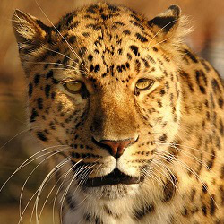

In [38]:
org_img

In [39]:
net.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [40]:
layer_list = ['conv1', 'layer1[0].conv3', 'layer4[2].conv2']
#layer_list = ['conv1']
exec_str_list = ["net."+layer +".register_forward_hook(hook)" for layer in layer_list]

In [41]:
layer_list = ['features[0]', 'features[3]']
#layer_list = ['conv1']
exec_str_list = ["net."+layer +".register_forward_hook(hook)" for layer in layer_list]

In [42]:
features = get_cnn_features(net, inputs, exec_str_list)

In [43]:
feat_norm_list = np.array([np.linalg.norm(features[i].detach().numpy().astype(np.float)) for i in range(len(features))], dtype= np.float32)

In [44]:
# Use the inverse of the squared norm of the CNN features as the weight for each layer
weights = 1. / (feat_norm_list**2)

In [45]:
weights

array([3.7099212e-06, 6.9072848e-07], dtype=float32)

In [46]:
# Normalise the weights such that the sum of the weights = 1
weights = weights / weights.sum()

#layer_weight = dict(zip(layer_list, weights))
layer_weight= dict(zip(exec_str_list, weights))

In [47]:
opts = {
    # Loss function type: {'l2', 'l1', 'inner', 'gram'}
    'loss_type': 'l2',
    
    'img_mean': img_mean,
    'img_std' : img_std,

    # The total number of iterations for gradient descend
    'iter_n': 200,

    # Display the information on the terminal for every n iterations
    'disp_every': 1,

    # Save the intermediate reconstruction or not
    'save_intermediate': True,
    # Save the intermediate reconstruction for every n iterations
    'save_intermediate_every': 10,
    # Path to the directory saving the intermediate reconstruction
    'save_intermediate_path': save_path,

    # Learning rate
    'lr_start': 2.,
    'lr_end': 1e-10,

    # Gradient with momentum
    'momentum_start': 0.9,
    'momentum_end': 0.9,

    # Pixel decay for each iteration
    'decay_start': 0.2,
    'decay_end': 1e-10,

    # Use image smoothing or not
    'image_blur': False,#True,
    # The size of the gaussian filter for image smoothing
    'sigma_start': 2.,
    'sigma_end': 0.5,

    # A python dictionary consists of weight parameter of each layer in the
    # loss function, arranged in pairs of layer name (key) and weight (value);
    'layer_weight': layer_weight,

    # The initial image for the optimization (setting to None will use random
    # noise as initial image)
    'initial_image': None,

    # A python dictionary consists of channels to be selected, arranged in
    # pairs of layer name (key) and channel numbers (value); the channel
    # numbers of each layer are the channels to be used in the loss function;
    # use all the channels if some layer not in the dictionary; setting to None
    # for using all channels for all layers;
    'channel': None,
    
    'exec_code': exec_str_list,
    
    #'bgr': False,
    'norm': norm,

    # A python dictionary consists of masks for the traget CNN features,
    # arranged in pairs of layer name (key) and mask (value); the mask selects
    # units for each layer to be used in the loss function (1: using the uint;
    # 0: excluding the unit); mask can be 3D or 2D numpy array; use all the
    # units if some layer not in the dictionary; setting to None for using all
    #units for all layers;
    'mask': None,
}

In [ ]:
recon_img, loss_list = reconstruct_image_upd(features, net, (224,224,3),**opts)

iter=1; err=4.54256;
iter=2; err=1437.18;
iter=3; err=1017.87;
iter=4; err=862.267;
iter=5; err=853.298;
iter=6; err=789.663;
iter=7; err=752.235;
iter=8; err=744.128;
iter=9; err=725.623;
iter=10; err=721.325;
iter=11; err=715.106;
iter=12; err=702.46;
iter=13; err=700.826;
iter=14; err=702.483;
iter=15; err=709.37;
iter=16; err=701.93;
iter=17; err=713.497;
iter=18; err=716.763;
iter=19; err=704.97;
iter=20; err=697.349;
iter=21; err=729.775;
iter=22; err=724.19;
iter=23; err=725.781;
iter=24; err=735.954;
iter=25; err=747.096;
iter=26; err=755.92;
iter=27; err=778.335;
iter=28; err=773.846;
iter=29; err=786.702;
iter=30; err=787.883;
iter=31; err=783.232;
iter=32; err=792.501;
iter=33; err=799.787;
iter=34; err=804.219;
iter=35; err=796.252;
iter=36; err=822.45;
